In [12]:
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd

luna_path = "data/LUNA/subset0/"
csv_path = "data/LUNA/CSVFILES/"
mhd_file = glob(luna_path + "*.mhd")

def get_pathname(file_id):
    global mhd_file
    for f in mhd_file:
        if file_id in f:
            return f
    
    

nodules = pd.read_csv(csv_path + "annotations.csv")
nodules['file'] = nodules['seriesuid'].apply(get_pathname)
nodules = nodules.dropna()

f = mhd_file[1]
nodule = nodules[nodules['file'] == f]

119
[ 110.  347.   33.]


/Users/Chuiye/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Chuiye/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


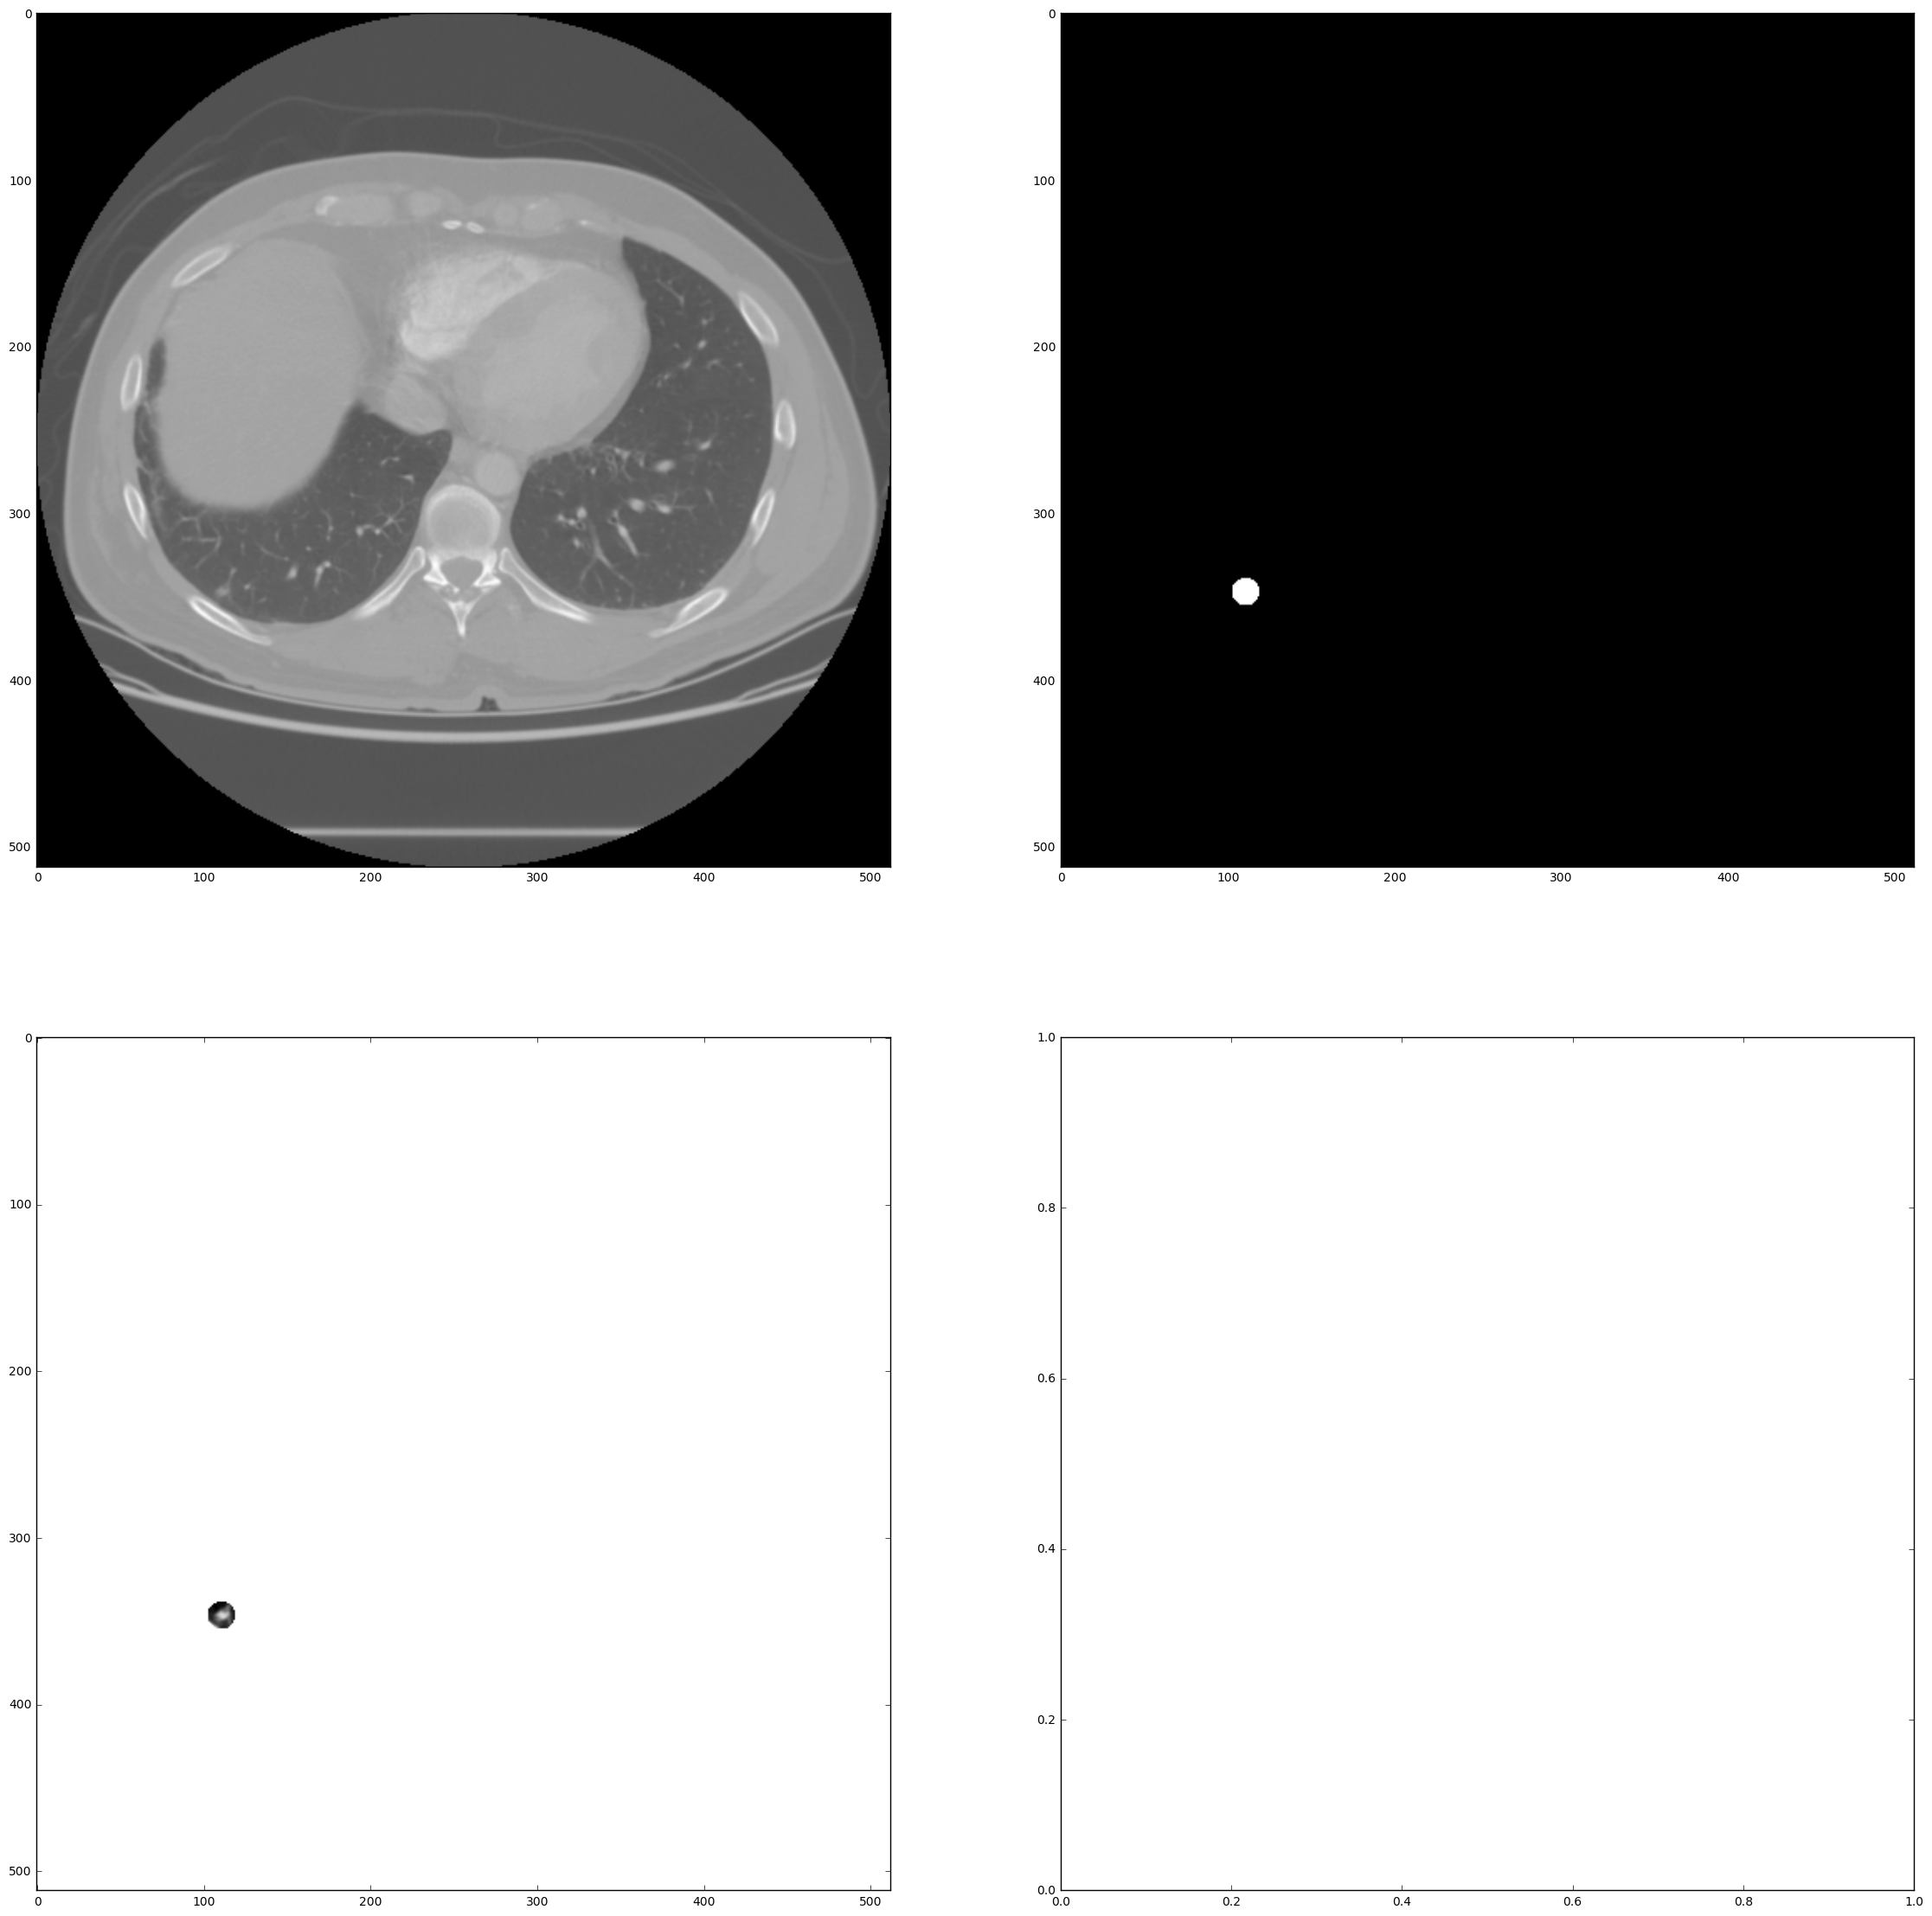

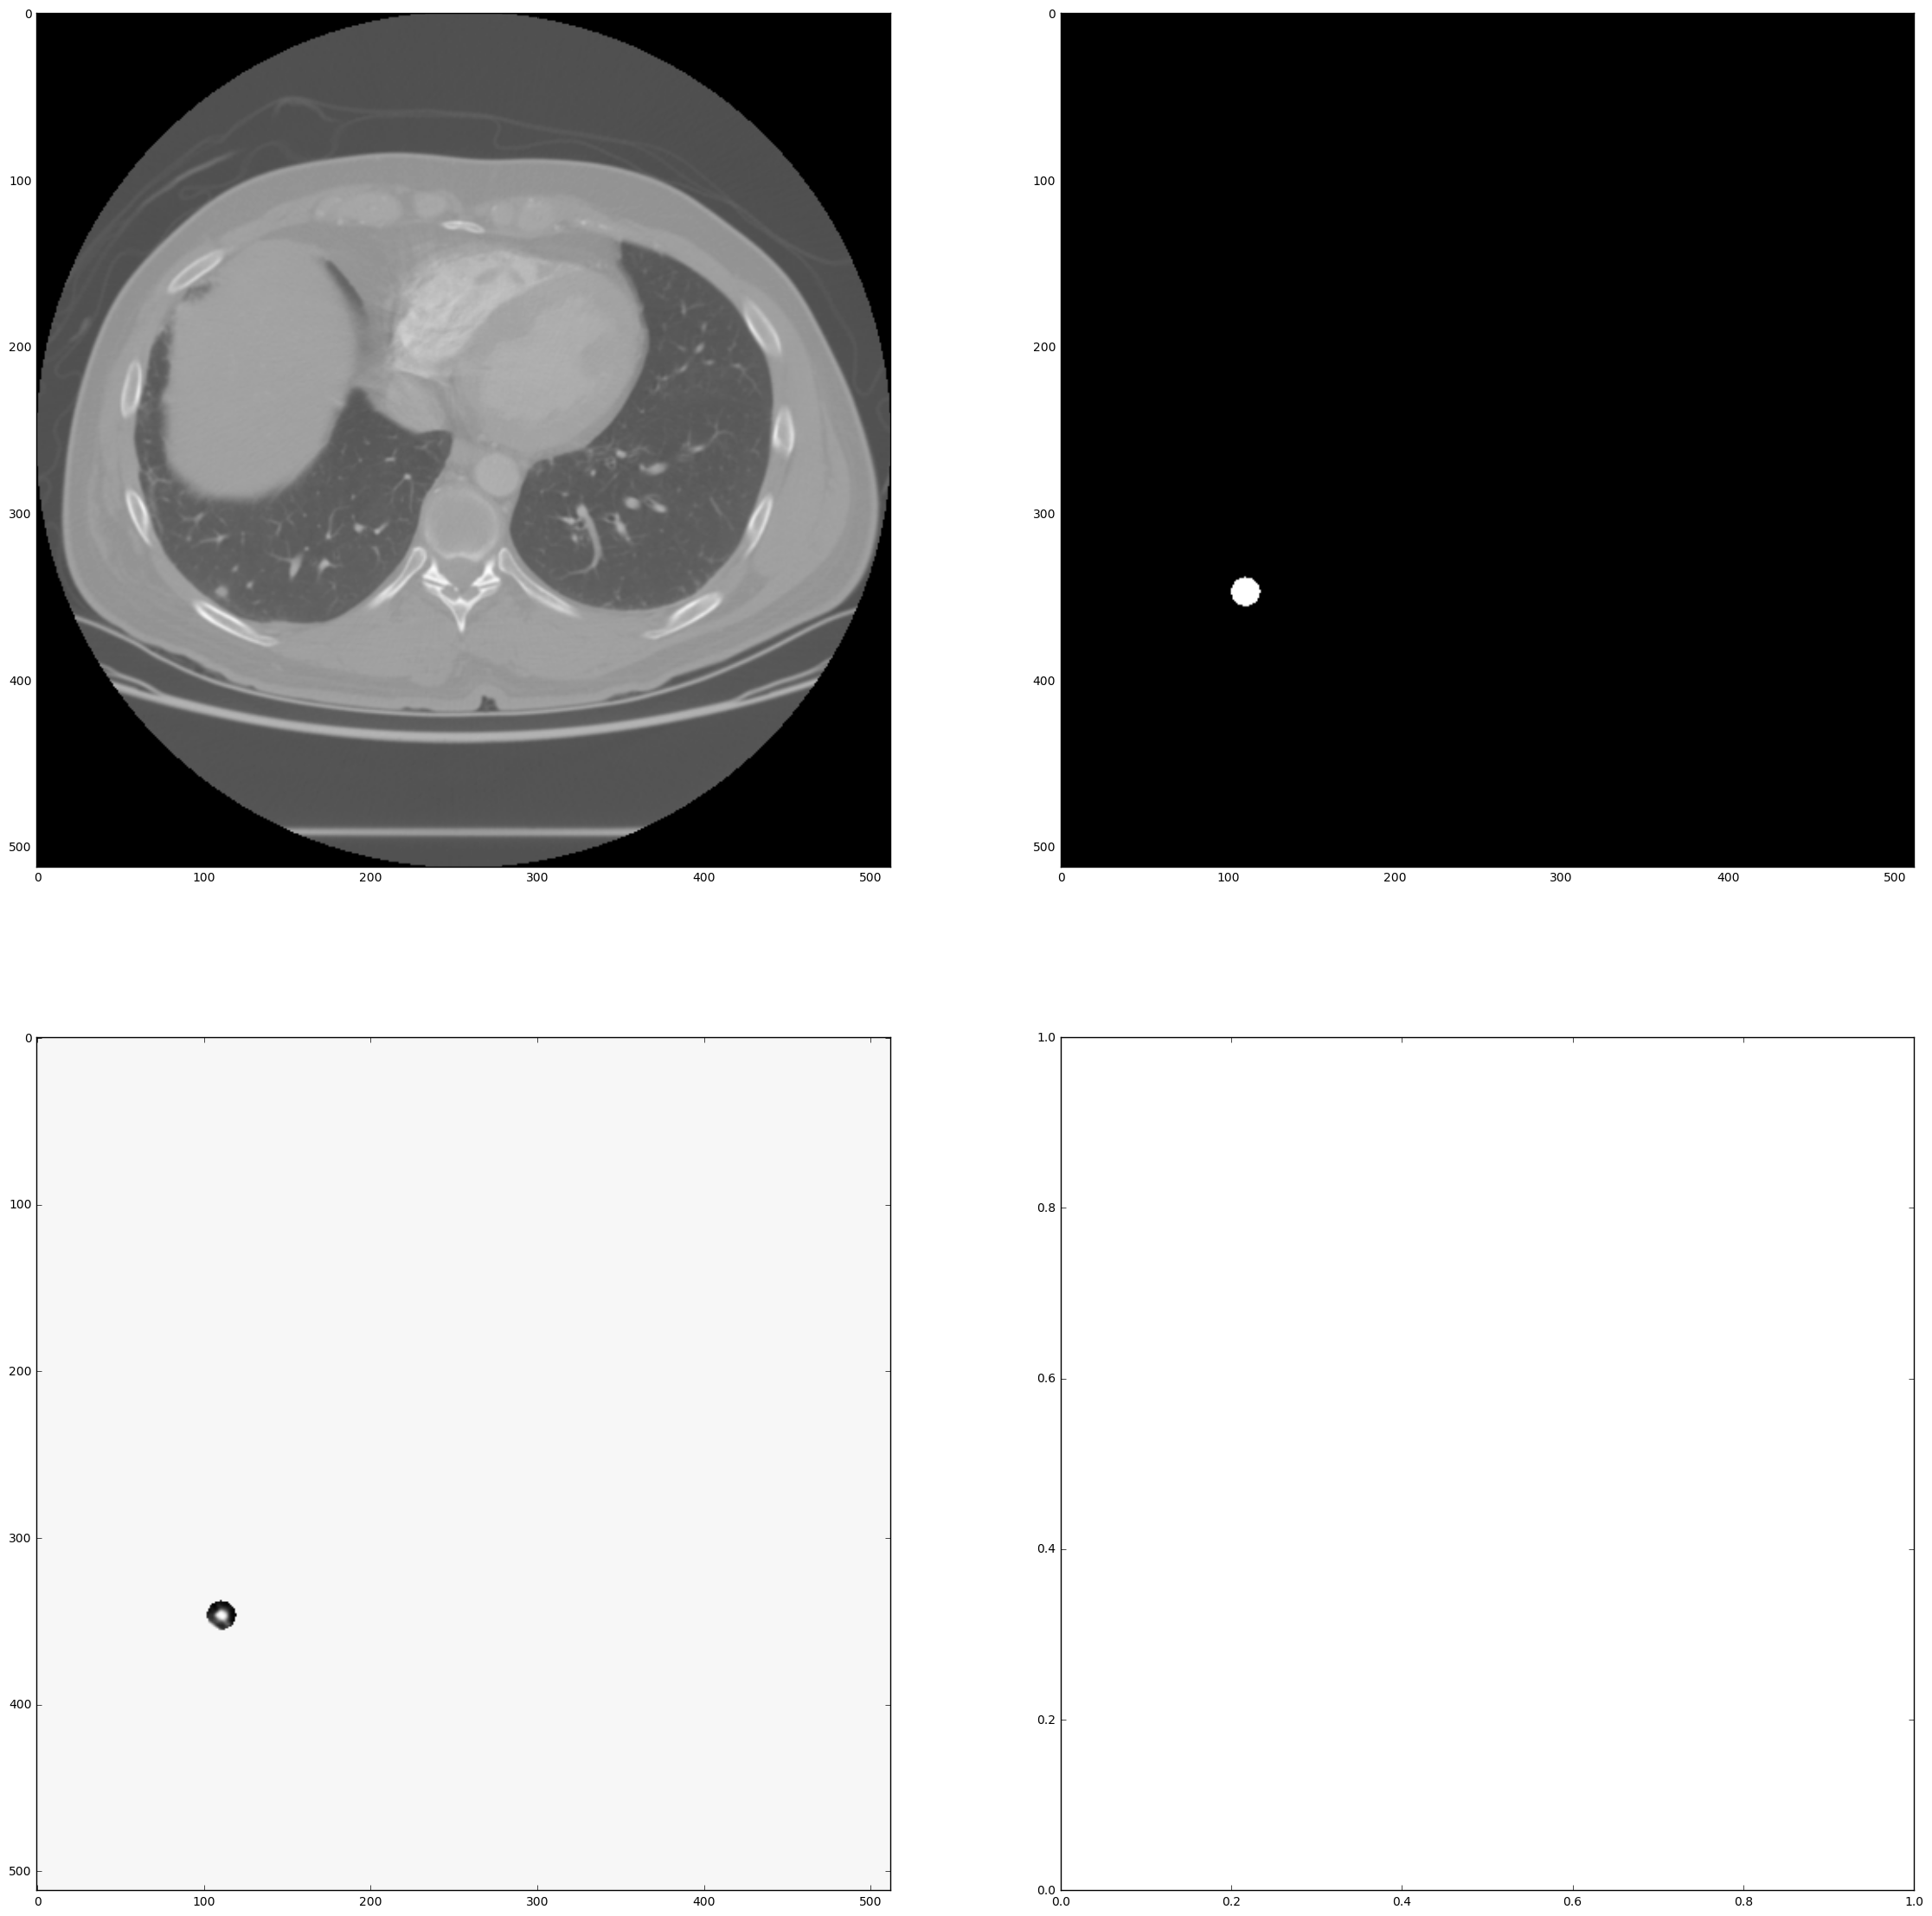

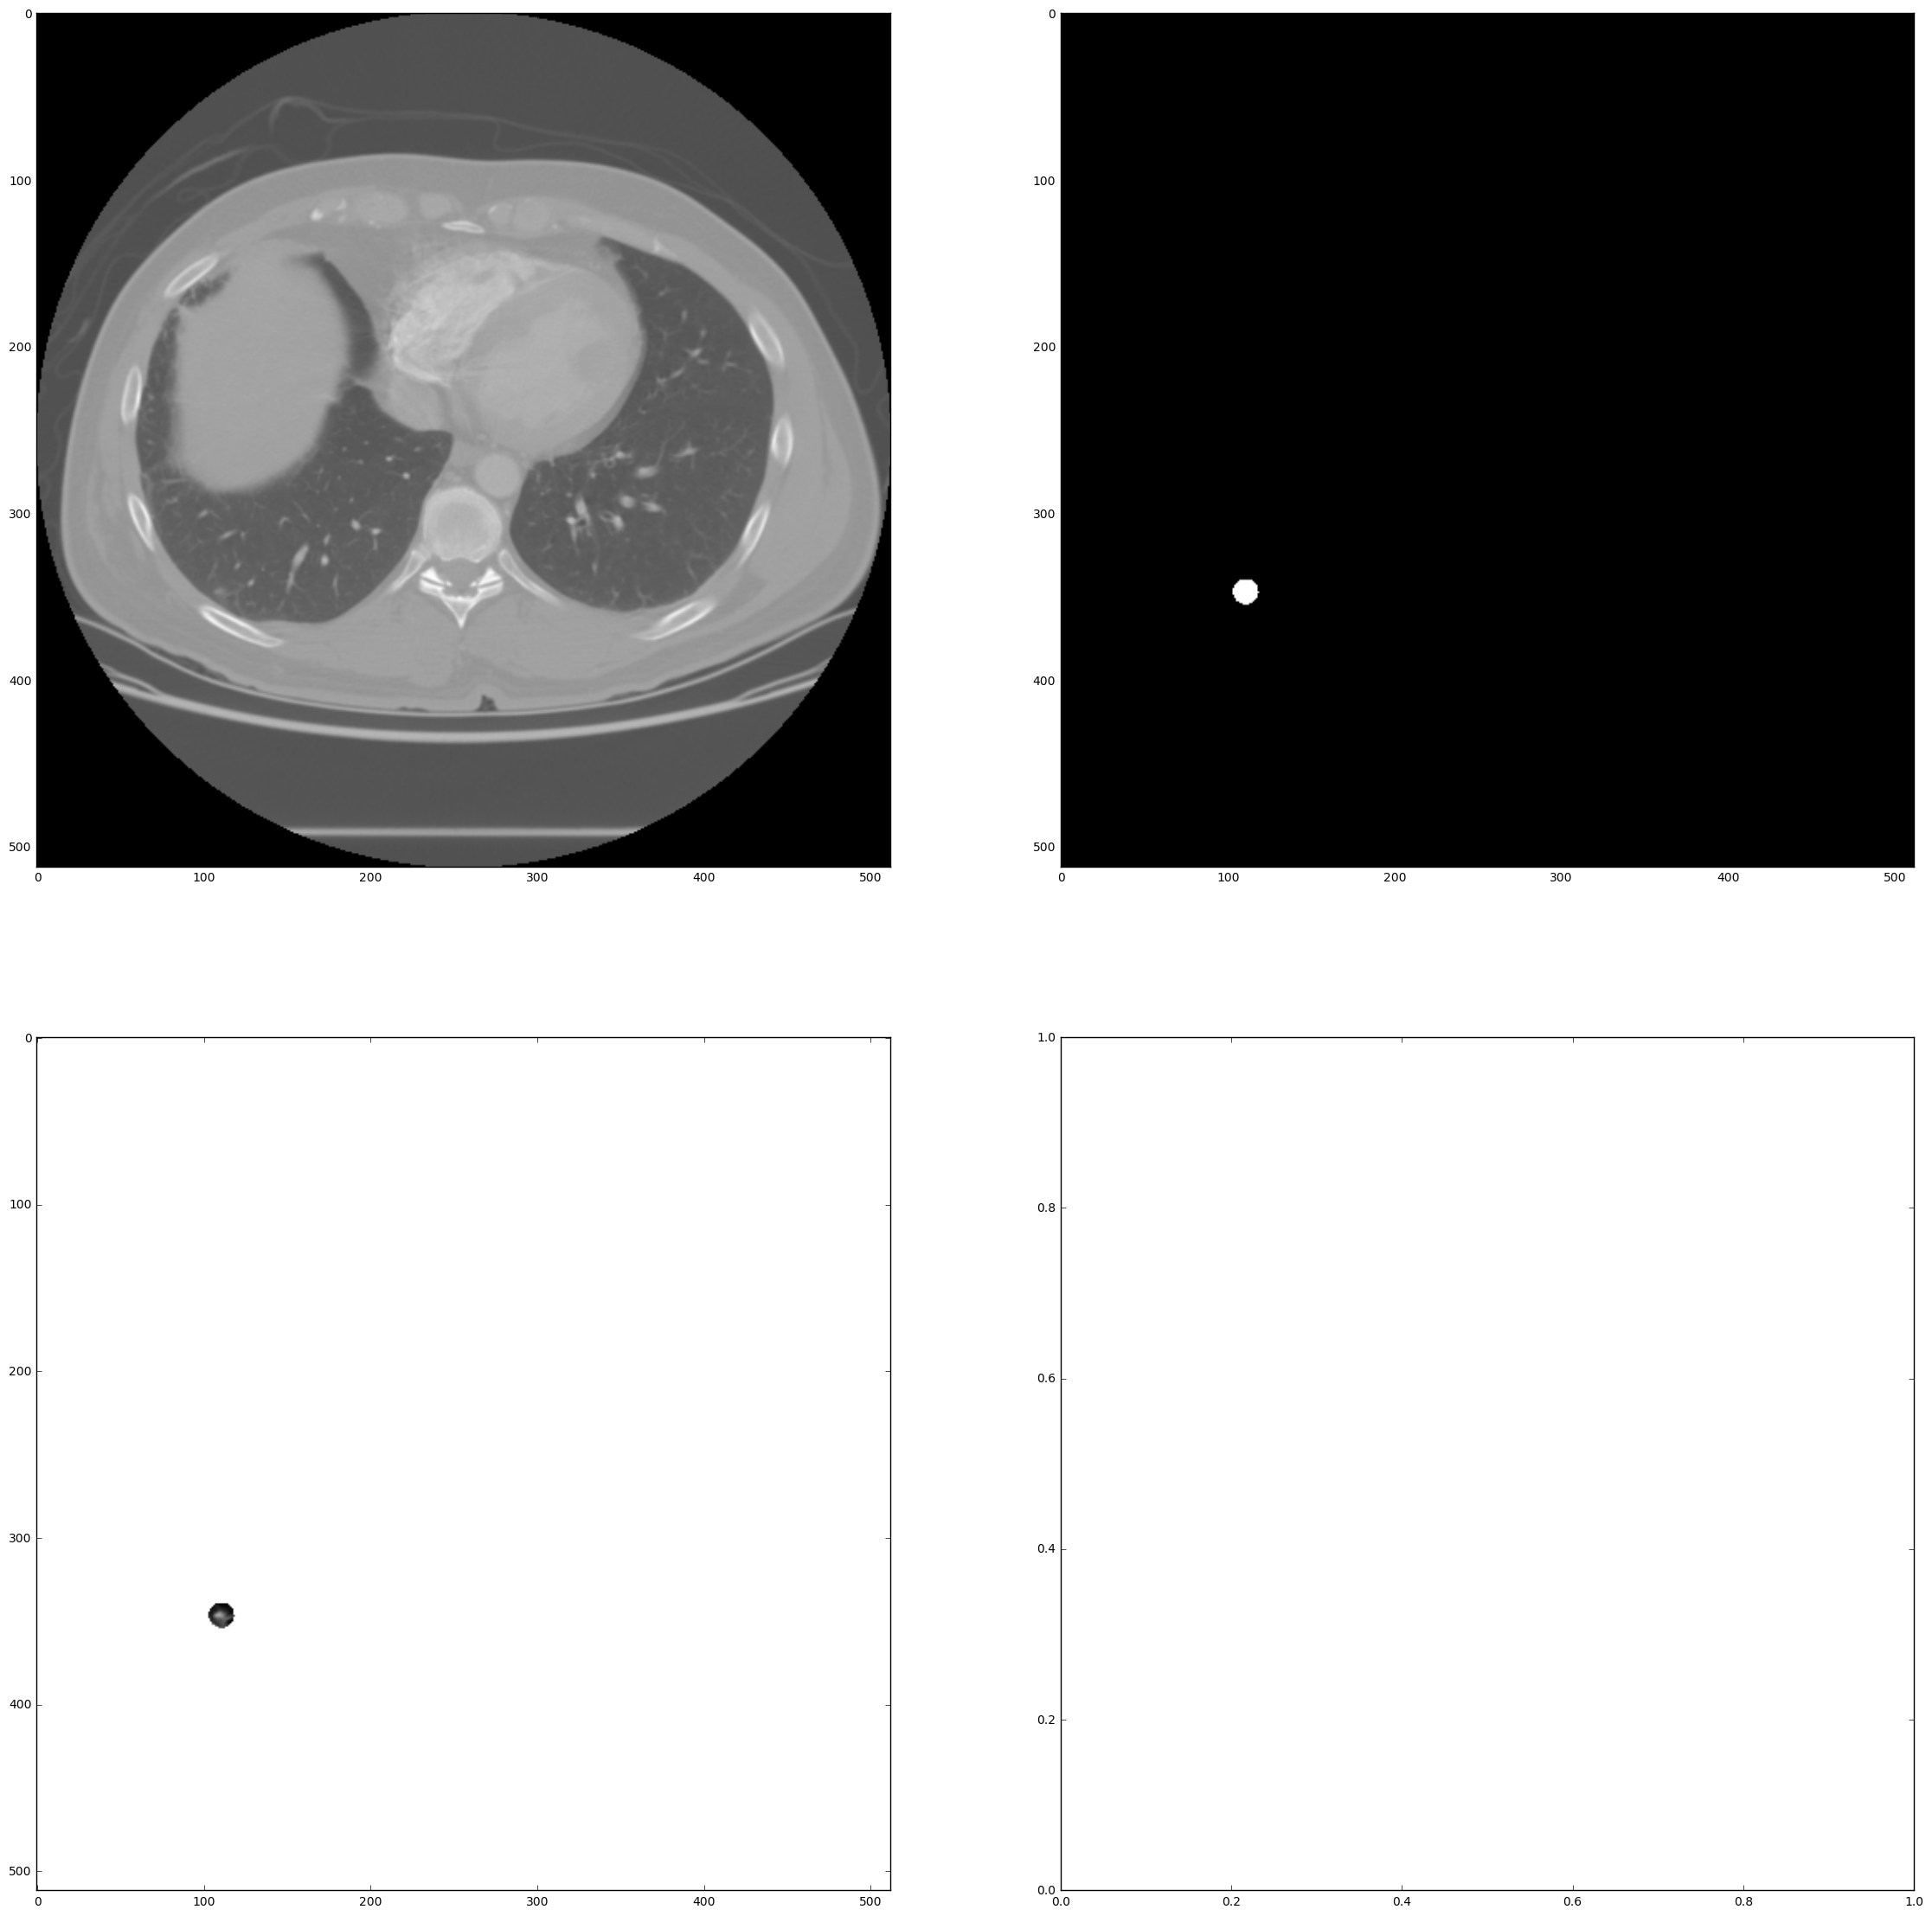

In [13]:
import matplotlib.pyplot as plt

def get_mask(center_pos, center, z_pos, origin, spacing, x_range, y_range, diam):
    mask = np.zeros([y_range, x_range])
    x_min = np.max([0, center_pos[0] - int(diam/spacing[0]) - 1])
    x_max = np.min([x_range, center_pos[0] + int(diam/spacing[0]) + 1])
    y_min = np.max([0, center_pos[1] - int(diam/spacing[0]) - 1])
    y_max = np.min([y_range, center_pos[1] + int(diam/spacing[0]) + 1])
    
    for x in np.arange(x_min, x_max + 1):
        for y in np.arange(y_min, y_max + 1):
            x_pos = x * spacing[0] + origin[0]
            y_pos = y * spacing[1] + origin[1]
            distance = np.linalg.norm(center - np.array([x_pos, y_pos, z_pos]))
            if distance  <= diam:
                mask[y, x] = 1.0
    return mask

if(len(nodule) > 0):
    index = np.argsort(nodule["diameter_mm"].values)[-1]
    x_pos = nodule['coordX'].values[index]
    y_pos = nodule['coordY'].values[index]
    z_pos = nodule['coordZ'].values[index]
    diam = nodule['diameter_mm'].values[index]
    image = sitk.ReadImage(f)
    image_array = sitk.GetArrayFromImage(image)
    length, width, height = image.GetSize()
    print(height)
    center = np.array([x_pos, y_pos, z_pos])
    origin = np.array(image.GetOrigin())
    spacing = np.array(image.GetSpacing())
    center_pos = np.rint((center - origin)/spacing)
    print(center_pos)
    masks = np.ndarray([3, width, length], dtype = np.uint8)
    images = np.ndarray([3, width, length], dtype = np.float32)
    for i, z in enumerate(np.arange(center_pos[2] - 1, center_pos[2] + 2).clip(0, height - 1)):
        masks[i] = get_mask(center_pos, center, z * spacing[2] + origin[2], origin, spacing, length, width, diam)
        images[i] = image_array[z]
        fig,ax = plt.subplots(2,2,figsize=[28,28])
        ax[0,0].imshow(images[i],cmap='gray')
        ax[0,1].imshow(masks[i],cmap='gray')
        ax[1,0].imshow(images[i]*masks[i],cmap='gray')
        plt.show()

In [14]:
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob

In [18]:
img = images[0]

(array([  1.13800000e+03,   5.44700000e+03,   1.15990000e+04,
          9.15900000e+03,   4.62100000e+03,   3.33700000e+03,
          7.09800000e+03,   7.94600000e+03,   3.67000000e+03,
          2.34000000e+03,   2.11300000e+03,   2.04400000e+03,
          2.08600000e+03,   2.20400000e+03,   2.62600000e+03,
          2.39200000e+03,   2.67400000e+03,   2.87100000e+03,
          2.97300000e+03,   2.84300000e+03,   2.43100000e+03,
          2.16100000e+03,   1.98200000e+03,   1.43000000e+03,
          1.25800000e+03,   1.10200000e+03,   9.49000000e+02,
          8.03000000e+02,   6.81000000e+02,   6.33000000e+02,
          5.25000000e+02,   4.93000000e+02,   4.74000000e+02,
          4.19000000e+02,   3.98000000e+02,   3.89000000e+02,
          3.85000000e+02,   3.42000000e+02,   3.03000000e+02,
          3.08000000e+02,   2.64000000e+02,   2.56000000e+02,
          2.50000000e+02,   2.72000000e+02,   2.52000000e+02,
          2.21000000e+02,   1.80000000e+02,   2.17000000e+02,
        

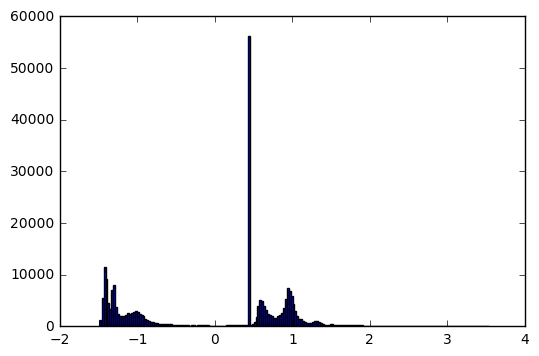

In [25]:
#for i in range(len(imgs_to_process)):
#    img = imgs_to_process[i]
    #Standardize the pixel values
mean = np.mean(img)
std = np.std(img)
img = img-mean
img = img/std
plt.hist(img.flatten(),bins=200)

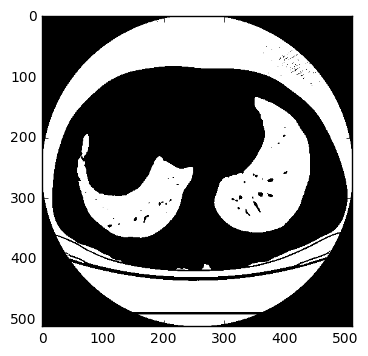

In [26]:
# Find the average pixel value near the lungs
# to renormalize washed out images
middle = img[100:400,100:400] 
mean = np.mean(middle)  
max = np.max(img)
min = np.min(img)

# To improve threshold finding, I'm moving the 
# underflow and overflow on the pixel spectrum
img[img==max]=mean
img[img==min]=mean
#
# Using Kmeans to separate foreground (radio-opaque tissue)
# and background (radio transparent tissue ie lungs)
# Doing this only on the center of the image to avoid 
# the non-tissue parts of the image as much as possible
#
kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

plt.imshow(thresh_img,cmap='gray')
plt.show()

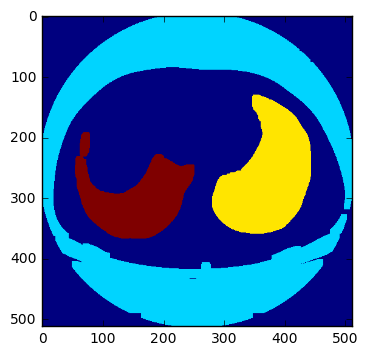

In [23]:
#
# I found an initial erosion helful for removing graininess from some of the regions
# and then large dialation is used to make the lung region 
# engulf the vessels and incursions into the lung cavity by 
# radio opaque tissue
#
eroded = morphology.erosion(thresh_img,np.ones([4,4]))
dilation = morphology.dilation(eroded,np.ones([10,10]))
#
#  Label each region and obtain the region properties
#  The background region is removed by removing regions 
#  with a bbox that is to large in either dimnsion
#  Also, the lungs are generally far away from the top 
#  and bottom of the image, so any regions that are too
#  close to the top and bottom are removed
#  This does not produce a perfect segmentation of the lungs
#  from the image, but it is surprisingly good considering its
#  simplicity. 
#
labels = measure.label(dilation)
label_vals = np.unique(labels)

plt.imshow(labels)
plt.show()

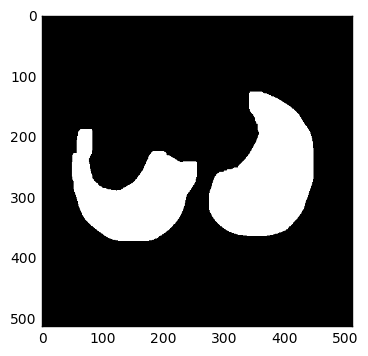

In [24]:
regions = measure.regionprops(labels)
good_labels = []
for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
        good_labels.append(prop.label)
mask = np.ndarray([512,512],dtype=np.int8)
mask[:] = 0
#
#  The mask here is the mask for the lungs--not the nodes
#  After just the lungs are left, we do another large dilation
#  in order to fill in and out the lung mask 
#
for N in good_labels:
    mask = mask + np.where(labels==N,1,0)
mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
#imgs_to_process[i] = mask
#np.save(img_file.replace("images","lungmask"),imgs_to_process)

plt.imshow(mask,cmap='gray')
plt.show()

In [27]:
node_mask = masks[0]
#out_images = []      #final set of images
#out_nodemasks = []   #final set of nodemasks

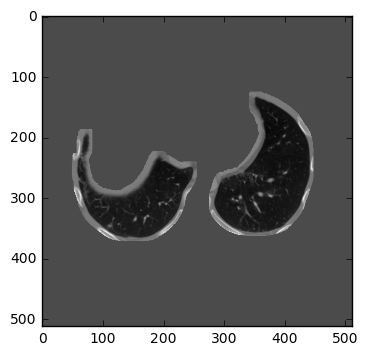

In [28]:
#
#    Here we're applying the masks and cropping and resizing the image
#

new_size = [512,512]   # we're scaling back up to the original size of the image
img= mask*img          # apply lung mask
#
# renormalizing the masked image (in the mask region)
#
new_mean = np.mean(img[mask>0])  
new_std = np.std(img[mask>0])
#
#  Pulling the background color up to the lower end
#  of the pixel range for the lungs
#
old_min = np.min(img)       # background color
img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
img = img-new_mean
img = img/new_std

plt.imshow(img,cmap='gray')
plt.show()

In [30]:
 #make image bounding box  (min row, min col, max row, max col)
labels = measure.label(mask)
regions = measure.regionprops(labels)
#
# Finding the global min and max row over all regions
#
min_row = 512
max_row = 0
min_col = 512
max_col = 0
for prop in regions:
    B = prop.bbox
    if min_row > B[0]:
        min_row = B[0]
    if min_col > B[1]:
        min_col = B[1]
    if max_row < B[2]:
        max_row = B[2]
    if max_col < B[3]:
        max_col = B[3]
width = max_col-min_col
height = max_row - min_row
if width > height:
    max_row=min_row+width
else:
    max_col = min_col+height
# 
# cropping the image down to the bounding box for all regions
# (there's probably an skimage command that can do this in one line)
# 
img = img[min_row:max_row,min_col:max_col]
mask =  mask[min_row:max_row,min_col:max_col]
if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
    pass
else:
    # moving range to -1 to 1 to accomodate the resize function
    mean = np.mean(img)
    img = img - mean
    min = np.min(img)
    max = np.max(img)
    img = img/(max-min)
    new_img = resize(img,[512,512])
    new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
    #out_images.append(new_img)
    #out_nodemasks.append(new_node_mask)

#num_images = len(out_images)
#
#  Writing out images and masks as 1 channel arrays for input into network
#
#final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
#final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
#for i in range(num_images):
#    final_images[i,0] = out_images[i]
#    final_masks[i,0] = out_nodemasks[i]

#rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
#test_i = int(0.2*num_images)
#np.save(working_path+"trainImages.npy",final_images[rand_i[test_i:]])
#np.save(working_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
#np.save(working_path+"testImages.npy",final_images[rand_i[:test_i]])
#np.save(working_path+"testMasks.npy",final_masks[rand_i[:test_i]])